# Tests

## Dependencies 

In [1]:
import requests
import os
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import pygadm
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data pipe 

In [2]:
save_directory = "rainpy/data/download"
name_stations = "zehn_now_rr_Beschreibung_Stationen.txt"
extract_directory = "../rainpy/data/extract"

In [3]:
file_path = os.path.join("../", save_directory, name_stations)
column_widths = [6, 9, 19, 8, 10, 8, 41, 50]
dtype_mapping = {7: str}
na_values = ['', ' ', 'NaN']
data_stations = pd.read_fwf(file_path, 
                 widths=column_widths, 
                 header=None, 
                 encoding="latin1", 
                 skiprows=2, 
                 dtype=dtype_mapping,
                 na_values=na_values)

In [4]:
data_stations.dtypes

0      int64
1      int64
2      int64
3      int64
4    float64
5    float64
6     object
7     object
dtype: object

In [5]:
data_stations.head()

0         1         2    3        4        5                         6  \
0  20  20040812  20230702  432  48.9219   9.9129  Abtsgmünd-Untergröningen   
1  44  20070208  20230702   44  52.9336   8.2370              Großenkneten   
2  53  20050831  20230702   60  52.5850  13.5634               Ahrensfelde   
3  73  20070213  20230702  340  48.6159  13.0506      Aldersbach-Kriestorf   
4  78  20041010  20230702   64  52.4853   7.9125                 Alfhausen   

                   7  
0  Baden-Württemberg  
1      Niedersachsen  
2        Brandenburg  
3             Bayern  
4      Niedersachsen

In [6]:
data_stations.iloc[:, -1] = data_stations.iloc[:, -1].str.strip()
data_stations.head()

0         1         2    3        4        5                         6  \
0  20  20040812  20230702  432  48.9219   9.9129  Abtsgmünd-Untergröningen   
1  44  20070208  20230702   44  52.9336   8.2370              Großenkneten   
2  53  20050831  20230702   60  52.5850  13.5634               Ahrensfelde   
3  73  20070213  20230702  340  48.6159  13.0506      Aldersbach-Kriestorf   
4  78  20041010  20230702   64  52.4853   7.9125                 Alfhausen   

                   7  
0  Baden-Württemberg  
1      Niedersachsen  
2        Brandenburg  
3             Bayern  
4      Niedersachsen

In [7]:
# Assign column names to the DataFrame
column_names = ["STATIONS_ID", "von_datum", "bis_datum", "Stationshoehe", "geoBreite", "geoLaenge", "Stationsname", "Bundesland"]
data_stations.columns = column_names

In [8]:
data_stations.reset_index(drop=True, inplace=True)

In [9]:
data_stations["von_datum"] = pd.to_datetime(data_stations["von_datum"], format="%Y%m%d")
data_stations["bis_datum"] = pd.to_datetime(data_stations["bis_datum"], format="%Y%m%d")

In [10]:
data_stations[["Stationshoehe", "geoBreite", "geoLaenge"]] = data_stations[["Stationshoehe", "geoBreite", "geoLaenge"]].astype(float)

In [11]:
data_stations

STATIONS_ID  von_datum  bis_datum  Stationshoehe  geoBreite  geoLaenge  \
0              20 2004-08-12 2023-07-02          432.0    48.9219     9.9129   
1              44 2007-02-08 2023-07-02           44.0    52.9336     8.2370   
2              53 2005-08-31 2023-07-02           60.0    52.5850    13.5634   
3              73 2007-02-13 2023-07-02          340.0    48.6159    13.0506   
4              78 2004-10-10 2023-07-02           64.0    52.4853     7.9125   
...           ...        ...        ...            ...        ...        ...   
1001        19140 2020-09-29 2023-07-02          278.0    50.9657    10.6988   
1002        19171 2020-08-20 2023-07-02           13.0    54.0039     9.8555   
1003        19172 2020-08-20 2023-07-02           48.0    54.0246     9.3880   
1004        19207 2023-03-30 2023-07-02           16.0    53.8178    12.0645   
1005        19299 2021-03-22 2023-07-02          463.0    49.8713    11.7883   

                  Stationsname              Bundesland  
0     Abtsgmünd-Untergröningen       Baden-Württemberg  
1                 Großenkneten           Niedersachsen  
2                  Ahrensfelde             Brandenburg  
3         Aldersbach-Kriestorf                  Bayern  
4                    Alfhausen           Niedersachsen  
...                        ...                     ...  
1001                     Gotha               Thüringen  
1002        Hasenkrug-Hardebek      Schleswig-Holstein  
1003                    Wacken      Schleswig-Holstein  
1004             Gülzow-Prüzen  Mecklenburg-Vorpommern  
1005             Speichersdorf                  Bayern  

[1006 rows x 8 columns]

In [12]:
dfs = []
# Loop through all files in extract 
for file_name in os.listdir(extract_directory):
    if file_name.startswith("produkt_zehn_now_rr_") and file_name.endswith(".txt"):
        file_path = os.path.join(extract_directory, file_name)
        df = pd.read_csv(file_path, sep=";", header=0)
        dfs.append(df)

In [13]:
merged_df = pd.concat(dfs)

In [14]:
merged_df.head()

STATIONS_ID    MESS_DATUM    QN  RWS_DAU_10  RWS_10  RWS_IND_10  eor
0         4393  202307020000     2           0     0.0           0  eor
1         4393  202307020010     2           0     0.0           0  eor
2         4393  202307020020     2           0     0.0           0  eor
3         4393  202307020030     2           0     0.0           0  eor
4         4393  202307020040     2           0     0.0           0  eor

In [15]:
merged_df["MESS_DATUM"] = pd.to_datetime(merged_df["MESS_DATUM"], format = "%Y%m%d%H%M")

In [16]:
merged_df["RWS_IND_10"].unique()

array([   0,    1, -999])

In [17]:
most_recent_date = merged_df.loc[:,"MESS_DATUM"].max()
most_recent_date

Timestamp('2023-07-02 11:50:00')

In [18]:
data = merged_df.loc[merged_df["MESS_DATUM"] == most_recent_date]
data = data.drop("eor", axis=1)

In [19]:
data["RWS_IND_10"].unique()

array([-999,    1,    0])

In [20]:
data = data.loc[data["RWS_IND_10"] != -999]

In [21]:
data

STATIONS_ID          MESS_DATUM    QN  RWS_DAU_10  RWS_10  RWS_IND_10
71         3167 2023-07-02 11:50:00     2           4     0.0           1
71         3946 2023-07-02 11:50:00     2           0     0.0           0
71         3761 2023-07-02 11:50:00     2           0     0.0           0
71         1639 2023-07-02 11:50:00     2           0     0.0           0
71         1605 2023-07-02 11:50:00     2           0     0.0           0
..          ...                 ...   ...         ...     ...         ...
71          853 2023-07-02 11:50:00     2           0     0.0           0
71         2261 2023-07-02 11:50:00     2           0     0.0           0
71         5490 2023-07-02 11:50:00     2           0     0.0           0
71         4177 2023-07-02 11:50:00     2           0     0.0           0
71         1580 2023-07-02 11:50:00     2           0     0.0           0

[142 rows x 6 columns]

In [22]:
data_stations

STATIONS_ID  von_datum  bis_datum  Stationshoehe  geoBreite  geoLaenge  \
0              20 2004-08-12 2023-07-02          432.0    48.9219     9.9129   
1              44 2007-02-08 2023-07-02           44.0    52.9336     8.2370   
2              53 2005-08-31 2023-07-02           60.0    52.5850    13.5634   
3              73 2007-02-13 2023-07-02          340.0    48.6159    13.0506   
4              78 2004-10-10 2023-07-02           64.0    52.4853     7.9125   
...           ...        ...        ...            ...        ...        ...   
1001        19140 2020-09-29 2023-07-02          278.0    50.9657    10.6988   
1002        19171 2020-08-20 2023-07-02           13.0    54.0039     9.8555   
1003        19172 2020-08-20 2023-07-02           48.0    54.0246     9.3880   
1004        19207 2023-03-30 2023-07-02           16.0    53.8178    12.0645   
1005        19299 2021-03-22 2023-07-02          463.0    49.8713    11.7883   

                  Stationsname              Bundesland  
0     Abtsgmünd-Untergröningen       Baden-Württemberg  
1                 Großenkneten           Niedersachsen  
2                  Ahrensfelde             Brandenburg  
3         Aldersbach-Kriestorf                  Bayern  
4                    Alfhausen           Niedersachsen  
...                        ...                     ...  
1001                     Gotha               Thüringen  
1002        Hasenkrug-Hardebek      Schleswig-Holstein  
1003                    Wacken      Schleswig-Holstein  
1004             Gülzow-Prüzen  Mecklenburg-Vorpommern  
1005             Speichersdorf                  Bayern  

[1006 rows x 8 columns]

In [23]:
data_analysis = pd.merge(data, data_stations, on=["STATIONS_ID"], how="left")

In [24]:
data_analysis

STATIONS_ID          MESS_DATUM    QN  RWS_DAU_10  RWS_10  RWS_IND_10  \
0           3167 2023-07-02 11:50:00     2           4     0.0           1   
1           3946 2023-07-02 11:50:00     2           0     0.0           0   
2           3761 2023-07-02 11:50:00     2           0     0.0           0   
3           1639 2023-07-02 11:50:00     2           0     0.0           0   
4           1605 2023-07-02 11:50:00     2           0     0.0           0   
..           ...                 ...   ...         ...     ...         ...   
137          853 2023-07-02 11:50:00     2           0     0.0           0   
138         2261 2023-07-02 11:50:00     2           0     0.0           0   
139         5490 2023-07-02 11:50:00     2           0     0.0           0   
140         4177 2023-07-02 11:50:00     2           0     0.0           0   
141         1580 2023-07-02 11:50:00     2           0     0.0           0   

     von_datum  bis_datum  Stationshoehe  geoBreite  geoLaenge  \
0   1999-06-01 2023-07-02          547.0    50.6621     7.9603   
1   1991-11-01 2023-07-02          387.0    50.4818    12.1300   
2   1992-07-01 2023-07-02          276.0    49.2070     9.5176   
3   1996-10-14 2023-07-02          203.0    50.6017     8.6439   
4   1991-11-05 2023-07-02           35.0    52.3875    12.1602   
..         ...        ...            ...        ...        ...   
137 1991-11-06 2023-07-02          416.0    50.7913    12.8720   
138 1998-02-11 2023-07-02          565.0    50.3123    11.8760   
139 1991-10-31 2023-07-02          233.0    51.8454    10.7686   
140 2008-10-28 2023-07-02          116.0    48.9726     8.3301   
141 1997-01-01 2023-07-02          111.0    49.9859     7.9548   

          Stationsname         Bundesland  
0      Marienberg, Bad    Rheinland-Pfalz  
1               Plauen            Sachsen  
2             Öhringen  Baden-Württemberg  
3    Gießen/Wettenberg             Hessen  
4              Genthin     Sachsen-Anhalt  
..                 ...                ...  
137           Chemnitz            Sachsen  
138                Hof             Bayern  
139        Wernigerode     Sachsen-Anhalt  
140       Rheinstetten  Baden-Württemberg  
141         Geisenheim             Hessen  

[142 rows x 13 columns]

In [25]:
data_analysis.columns = data_analysis.columns.str.strip()

In [26]:
subset_columns = ["STATIONS_ID", "MESS_DATUM", "RWS_10", "RWS_IND_10", "Stationshoehe", "geoLaenge", "geoBreite", "Stationsname", "Bundesland"]
data_analysis = data_analysis.loc[:,subset_columns]

In [27]:
data_analysis

STATIONS_ID          MESS_DATUM  RWS_10  RWS_IND_10  Stationshoehe  \
0           3167 2023-07-02 11:50:00     0.0           1          547.0   
1           3946 2023-07-02 11:50:00     0.0           0          387.0   
2           3761 2023-07-02 11:50:00     0.0           0          276.0   
3           1639 2023-07-02 11:50:00     0.0           0          203.0   
4           1605 2023-07-02 11:50:00     0.0           0           35.0   
..           ...                 ...     ...         ...            ...   
137          853 2023-07-02 11:50:00     0.0           0          416.0   
138         2261 2023-07-02 11:50:00     0.0           0          565.0   
139         5490 2023-07-02 11:50:00     0.0           0          233.0   
140         4177 2023-07-02 11:50:00     0.0           0          116.0   
141         1580 2023-07-02 11:50:00     0.0           0          111.0   

     geoLaenge  geoBreite       Stationsname         Bundesland  
0       7.9603    50.6621    Marienberg, Bad    Rheinland-Pfalz  
1      12.1300    50.4818             Plauen            Sachsen  
2       9.5176    49.2070           Öhringen  Baden-Württemberg  
3       8.6439    50.6017  Gießen/Wettenberg             Hessen  
4      12.1602    52.3875            Genthin     Sachsen-Anhalt  
..         ...        ...                ...                ...  
137    12.8720    50.7913           Chemnitz            Sachsen  
138    11.8760    50.3123                Hof             Bayern  
139    10.7686    51.8454        Wernigerode     Sachsen-Anhalt  
140     8.3301    48.9726       Rheinstetten  Baden-Württemberg  
141     7.9548    49.9859         Geisenheim             Hessen  

[142 rows x 9 columns]

In [28]:
data_analysis.columns = ["id", "date", "prec", "prec_ind", "alt", "long", "lat", "station_name", "state"]

In [29]:
data_analysis

id                date  prec  prec_ind    alt     long      lat  \
0    3167 2023-07-02 11:50:00   0.0         1  547.0   7.9603  50.6621   
1    3946 2023-07-02 11:50:00   0.0         0  387.0  12.1300  50.4818   
2    3761 2023-07-02 11:50:00   0.0         0  276.0   9.5176  49.2070   
3    1639 2023-07-02 11:50:00   0.0         0  203.0   8.6439  50.6017   
4    1605 2023-07-02 11:50:00   0.0         0   35.0  12.1602  52.3875   
..    ...                 ...   ...       ...    ...      ...      ...   
137   853 2023-07-02 11:50:00   0.0         0  416.0  12.8720  50.7913   
138  2261 2023-07-02 11:50:00   0.0         0  565.0  11.8760  50.3123   
139  5490 2023-07-02 11:50:00   0.0         0  233.0  10.7686  51.8454   
140  4177 2023-07-02 11:50:00   0.0         0  116.0   8.3301  48.9726   
141  1580 2023-07-02 11:50:00   0.0         0  111.0   7.9548  49.9859   

          station_name              state  
0      Marienberg, Bad    Rheinland-Pfalz  
1               Plauen            Sachsen  
2             Öhringen  Baden-Württemberg  
3    Gießen/Wettenberg             Hessen  
4              Genthin     Sachsen-Anhalt  
..                 ...                ...  
137           Chemnitz            Sachsen  
138                Hof             Bayern  
139        Wernigerode     Sachsen-Anhalt  
140       Rheinstetten  Baden-Württemberg  
141         Geisenheim             Hessen  

[142 rows x 9 columns]

# Start the Geo-Analysis

In [42]:
data_path = "../rainpy/data/"
file = "data_analysis.pkl"

In [43]:
with open(os.path.join(data_path, file), 'rb') as f:
    data_analysis = pickle.load(f)

In [44]:
data_analysis.head()

id                date  prec_dur  prec  prec_ind    alt     long  \
0  5099 2023-07-02 12:50:00      -999   0.0      -999  132.0   6.6131   
1  1214 2023-07-02 12:50:00      -999   0.0      -999  431.0   8.1088   
2  4813 2023-07-02 12:50:00      -999   0.0      -999  318.0  11.0467   
3  3167 2023-07-02 12:50:00         0   0.0         0  547.0   7.9603   
4  7329 2023-07-02 12:50:00      -999   0.0      -999  465.0  12.2863   

       lat                station_name              state  
0  49.7326                 Trier-Zewen    Rheinland-Pfalz  
1  48.2012             Elzach-Fisnacht  Baden-Württemberg  
2  50.0806  Staffelstein, Bad-Stublang             Bayern  
3  50.6621             Marienberg, Bad    Rheinland-Pfalz  
4  50.5467                      Treuen            Sachsen

In [51]:
data_analysis["prec"].unique()

array([0.  , 0.01])

In [46]:
data_analysis['geometry'] = data_analysis.apply(lambda row: Point(row['long'], row['lat']), axis=1)

In [47]:
geo_data_analysis = gpd.GeoDataFrame(data_analysis.drop(["long", "lat"], axis=1), geometry="geometry")

In [48]:
geo_data_analysis

id                date  prec_dur  prec  prec_ind    alt  \
0    5099 2023-07-02 12:50:00      -999   0.0      -999  132.0   
1    1214 2023-07-02 12:50:00      -999   0.0      -999  431.0   
2    4813 2023-07-02 12:50:00      -999   0.0      -999  318.0   
3    3167 2023-07-02 12:50:00         0   0.0         0  547.0   
4    7329 2023-07-02 12:50:00      -999   0.0      -999  465.0   
..    ...                 ...       ...   ...       ...    ...   
291  4605 2023-07-02 12:50:00      -999   0.0      -999  277.0   
292  4177 2023-07-02 12:50:00         0   0.0         0  116.0   
293  3181 2023-07-02 12:50:00      -999   0.0      -999  360.0   
294  4349 2023-07-02 12:50:00      -999   0.0      -999  251.0   
295  1580 2023-07-02 12:50:00         0   0.0         0  111.0   

                   station_name              state                   geometry  
0                   Trier-Zewen    Rheinland-Pfalz   POINT (6.61310 49.73260)  
1               Elzach-Fisnacht  Baden-Württemberg   POINT (8.10880 48.20120)  
2    Staffelstein, Bad-Stublang             Bayern  POINT (11.04670 50.08060)  
3               Marienberg, Bad    Rheinland-Pfalz   POINT (7.96030 50.66210)  
4                        Treuen            Sachsen  POINT (12.28630 50.54670)  
..                          ...                ...                        ...  
291                 Schwarzburg          Thüringen  POINT (11.19360 50.64410)  
292                Rheinstetten  Baden-Württemberg   POINT (8.33010 48.97260)  
293    Markt Erlbach-Hagenhofen             Bayern  POINT (10.62770 49.48750)  
294                 Sachsenheim  Baden-Württemberg   POINT (9.07110 48.95690)  
295                  Geisenheim             Hessen   POINT (7.95480 49.98590)  

[296 rows x 9 columns]

In [49]:
de = pygadm.get_items(admin="DEU", content_level=0)

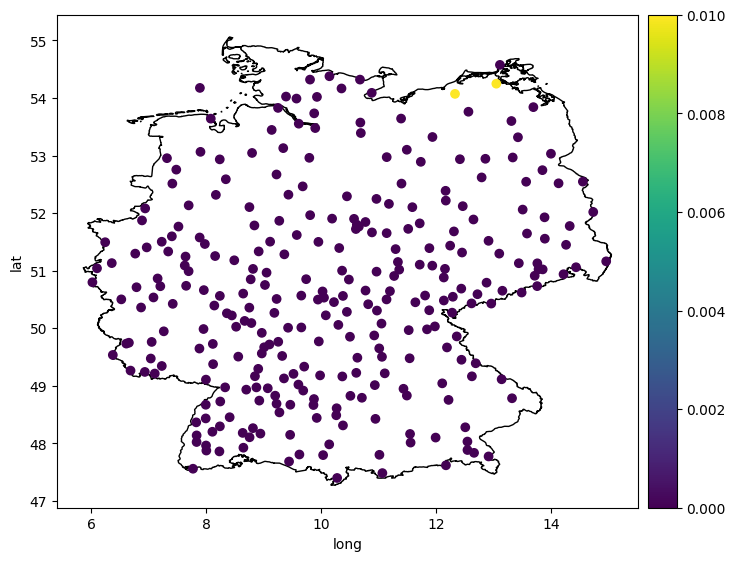

In [50]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 15))
divider = make_axes_locatable(ax)

# create `cax` for the colorbar
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the borders
de.plot(ax=ax, facecolor='white', edgecolor='black')

# Plot the rainfall at the stations and get the legend object
geo_data_analysis.plot(column='prec', ax=ax, legend=True, cax=cax)
ax.set_xlabel("long")
ax.set_ylabel("lat")

plt.show()

## Check missing values

In [17]:
file = "merged_data.pkl"

In [18]:
with open(os.path.join(data_path, file), 'rb') as f:
    merged_data = pickle.load(f)

In [19]:
# Transform the column "MESS_DATUM" to a datetime format
merged_data.loc[:,"MESS_DATUM"] = pd.to_datetime(merged_data.loc[:,"MESS_DATUM"], format = "%Y%m%d%H")

# Obtain the most recent date
most_recent_date = merged_data.loc[:,"MESS_DATUM"].max()

# Filter the data to obtain the most recent date 
data = merged_data.loc[merged_data["MESS_DATUM"] == most_recent_date]

# Drop the eor column 
data = data.drop("eor", axis=1)

In [20]:
data

STATIONS_ID          MESS_DATUM  QN_8    R1  RS_IND  WRTR
13199         5009 2023-06-12 23:00:00     1   0.0       0  -999
13197         6266 2023-06-12 23:00:00     1   0.0       0  -999
13192          617 2023-06-12 23:00:00     1   0.0       0  -999
13196         2014 2023-06-12 23:00:00     1   0.0       0     0
13099         6272 2023-06-12 23:00:00     1   0.0       0  -999
...            ...                 ...   ...   ...     ...   ...
13199         5762 2023-06-12 23:00:00     1   0.0       0  -999
13170         5986 2023-06-12 23:00:00     1   0.0       0  -999
13199         6257 2023-06-12 23:00:00     1   0.0       0  -999
13173         5992 2023-06-12 23:00:00     1   0.0       0  -999
13199          154 2023-06-12 23:00:00     1   0.0       0  -999

[989 rows x 6 columns]

In [6]:
data_analysis

id                date  prec  prec_ind  WRTR    alt     long      lat  \
0    2014 2023-06-12 23:00:00   0.0         0     0   55.0   9.6779  52.4644   
1     603 2023-06-12 23:00:00   0.0         0     0  147.0   7.2040  50.7293   
2    2564 2023-06-12 23:00:00   0.0         0     0   28.0  10.1424  54.3776   
3    1694 2023-06-12 23:00:00   0.0         0     0   59.0  12.1034  53.6058   
4    5800 2023-06-12 23:00:00   0.0         0     0  615.0  13.2385  49.0280   
..    ...                 ...   ...       ...   ...    ...      ...      ...   
164   342 2023-06-12 23:00:00   0.0         0     0  103.0   8.1694  52.3170   
165  1048 2023-06-12 23:00:00   0.0         0     0  228.0  13.7543  51.1278   
166  2794 2023-06-12 23:00:00   0.0         0     0   40.0  12.4093  52.9362   
167   183 2023-06-12 23:00:00   0.0         0     0   42.0  13.4344  54.6791   
168  1262 2023-06-12 23:00:00   0.0         0     0  446.0  11.8134  48.3477   

               station_name                   state  
0                  Hannover           Niedersachsen  
1    Königswinter-Heiderhof     Nordrhein-Westfalen  
2             Kiel-Holtenau      Schleswig-Holstein  
3                  Goldberg  Mecklenburg-Vorpommern  
4                   Zwiesel                  Bayern  
..                      ...                     ...  
164                    Belm           Niedersachsen  
165       Dresden-Klotzsche                 Sachsen  
166                  Kyritz             Brandenburg  
167                  Arkona  Mecklenburg-Vorpommern  
168       München-Flughafen                  Bayern  

[169 rows x 10 columns]